# Testing with API Gateway

In [4]:
# %%capture
# %pip install aws-requests-auth

In [5]:
import json
import time

import matplotlib.pyplot as plt
import numpy as np
import requests
from aws_requests_auth.boto_utils import BotoAWSRequestsAuth
from tqdm.contrib.concurrent import thread_map

### Parameters

In [ ]:
url = ""

In [ ]:
test_phrase = "Hai, Sobat Polri. Bagi kamu yang akan mudik nanti khususnya yang mengendarai kendaraan pribadi, jaga keselamatan, ya. Jangan dipaksakan untuk berkendara apabila lelah. Silakan gunakan tempat-tempat yang telah disediakan untuk beristirahat :)"

In [ ]:
payload = {"inputs": test_phrase}
region = "ap-southeast-1"

In [ ]:
# auth = BotoAWSRequestsAuth(
#     aws_host=url.split("//")[-1],
#     aws_region=region,
#     aws_service="execute-api",
# )


response = requests.get(
    url,
    # auth=auth,
    params=payload,
)
print(json.dumps(response.json(), indent=2))

## Benchmark

In [73]:
def time_prediction(payload, return_pred=False):
    t1 = time.time()
    pred = requests.get(url, params=payload)
    if return_pred:
        return pred
    if pred.status_code != 200:
        return None
    return time.time() - t1


def run_benchmark(
    payload,
    num_preds=100,
    print_report=False,
    plot_report=False,
    n_threads=None,
):
    tic = time.time()
    t_vec = thread_map(
        time_prediction,
        [payload] * num_preds,
        max_workers=n_threads,
    )
    duration = time.time() - tic
    n_failed = np.count_nonzero(np.isnan(t_vec))
    TPS = num_preds / duration

    latency_percentiles = np.percentile(t_vec, q=[50, 90, 95, 99])

    if plot_report:

        plt.hist(t_vec, bins=100)
        plt.title("Request latency histogram for ml.g4dn.xlarge")

        plt.show()

    if print_report:
        print(
            "==== HuggingFace model deployed on GPU instance endpoint benchmark ====\n",
            f"95 % of requests take less than {latency_percentiles[2]*1000} ms\n",
            f"Rough request throughput/second is {TPS}\n",
            f"{n_failed} failed invocations",
        )
    return TPS, latency_percentiles[2] * 1000, n_failed

  0%|          | 0/5000 [00:00<?, ?it/s]

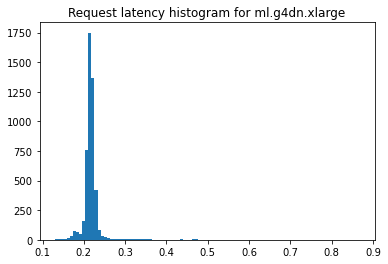

==== HuggingFace model deployed on GPU instance endpoint benchmark ====
 95 % of requests take less than 234.17949676513672 ms
 Rough request throughput/second is 27.32305523442689
 0 failed invocations


(27.32305523442689, 234.17949676513672, 0)

In [75]:
run_benchmark(payload, 5000, True, True)